# 02 — Exploratory Data Analysis on Missingness

In this notebook we characterize *how* and *when* the Seattle loop detectors go
missing over the course of 2015. Rather than treating missing entries as random
noise, we want to understand the structure of outages at both the sensor and
network level.

Concretely, we will:

- Quantify **per-detector reliability**:
  - Fraction of time each detector is missing.
  - How many blackout stretches each detector experiences.
  - How long those blackouts last (in 5-minute steps and minutes).

- Visualize **temporal patterns in missingness**:
  - Heatmaps over **weekday × hour of day** to see when dropouts are most likely.
  - Histograms of blackout lengths to separate short glitches from multi-hour outages.

- Identify **network-wide blackout events**:
  - For each timestamp, compute the fraction of detectors that are missing.
  - Mark intervals where ≥10% of the active detectors are down at once as
    “multi-sensor blackouts”.

The goal is to confirm that we are in a genuinely **MNAR** regime:
missingness is correlated across sensors, concentrated in certain time windows
(e.g., late-night maintenance), and organized into repeated blackout episodes.
These findings will then guide how we define blackout labels and how we build
and evaluate models that treat blackouts as information rather than as random
omissions.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit larger by default
plt.rcParams["figure.figsize"] = (10, 5)

In [15]:
# ============================================
# 0. Load cleaned panel from Step 1
# ============================================

# This file is produced in 01_load_and_clean.ipynb
try:
    # Prefer parquet (smaller, faster)
    wide = pd.read_parquet("data/seattle_loop_clean.parquet")
    print("Loaded clean panel from parquet.")
except Exception as e:
    print("Parquet load failed, falling back to pickle. Error was:")
    print(" ", e)
    wide = pd.read_pickle("data/seattle_loop_clean.pkl")
    print("Loaded clean panel from pickle.")

print("Wide panel shape:", wide.shape)
print("Time span:", wide.index.min(), "→", wide.index.max())

# Boolean missingness matrix (True = missing)
missing = wide.isna()
mask = missing.to_numpy()
timestamps = wide.index.to_numpy()
T, D = mask.shape
detectors = wide.columns.to_numpy()

print(f"T (time steps): {T},  D (detectors): {D}")
print("Overall missing fraction:", mask.mean())


Loaded clean panel from parquet.
Wide panel shape: (105120, 147)
Time span: 2015-01-01 00:00:00 → 2015-12-31 23:55:00
T (time steps): 105120,  D (detectors): 147
Overall missing fraction: 0.051772771513476014


- Shape of panel: $105{,}120 \times 147$ — corresponding to:
  - $T = 105{,}120$ time steps (i.e., 5-minute intervals over one full year: $365 \times 24 \times 12$)
  - $D = 147$ detectors

- Time coverage: **January 1, 2015, 00:00** → **December 31, 2015, 23:55**

- Overall missingness across all detector readings:
  $$
  \text{Missing fraction} = 5.18\%
  $$

In [16]:
# ============================================
# 1. Helper: streak finder (for blackouts)
# ============================================

def find_streaks(bool_array):
    """
    Find start and end indices of True streaks in a 1D boolean array.
    Returns a list of (start_idx, end_idx) pairs (inclusive).
    """
    out, start = [], None
    for i, v in enumerate(bool_array):
        if v and start is None:
            start = i
        elif not v and start is not None:
            out.append((start, i - 1))
            start = None
    if start is not None:
        out.append((start, len(bool_array) - 1))
    return out

We analyze missing data per detector by computing the following metrics:

- **Missing Fraction**: Proportion of time steps where data is missing ($\text{NaN}$).
- **Blackout Count**: Number of missing streaks of length $\geq 2$ time steps ($\geq 10$ minutes).
- **Mean/Max Blackout Length**: Average and maximum duration (in 5-minute steps) of these blackout events.

Let $x_t^d$ denote the reading at time $t$ for detector $d$. A blackout is defined as any maximal subsequence $\{x_{s}^d, x_{s+1}^d, \dots, x_{e}^d\}$ such that all entries are missing and $e - s + 1 \geq 2$.

In [17]:
# ============================================
# 2. Per-detector stats on missingness
#    - % missing
#    - # blackout stretches
#    - mean / max blackout length
# ============================================

print("\n[Per-detector missingness stats]")

# Fraction of missing readings per detector
missing_frac_per_sensor = missing.mean(axis=0)  # Series indexed by detector

per_sensor_rows = []
all_blackout_lengths_steps = []  # collect all blackout lengths for global histogram

# Define a blackout as a run of missing values of length >= MIN_LEN
MIN_LEN = 2  # 2 steps = 10 minutes at 5-min resolution

# For each detector, find sequences of consecutive NaNs
for j, det in enumerate(detectors):
    col_mask = mask[:, j]   # True when missing
    streaks = find_streaks(col_mask)  # store the long missing-data streaks for this detector
    
    # All streak lengths (in steps)
    lengths_all = [e - s + 1 for (s, e) in streaks]
    
    # Blackouts = streaks of length >= MIN_LEN
    blackout_lengths = [L for L in lengths_all if L >= MIN_LEN]
    num_blackouts = len(blackout_lengths)
    
    max_len = max(blackout_lengths) if blackout_lengths else 0
    mean_len = float(np.mean(blackout_lengths)) if blackout_lengths else 0.0
    
    all_blackout_lengths_steps.extend(blackout_lengths)
    
    per_sensor_rows.append({
        "detector": det,
        "missing_frac": missing_frac_per_sensor.loc[det],
        "num_blackouts": num_blackouts,
        "mean_blackout_len_steps": mean_len,
        "max_blackout_len_steps": max_len,
    })

per_sensor_stats = pd.DataFrame(per_sensor_rows).set_index("detector")

print("\nPer-sensor stats (head):")
print(per_sensor_stats.head())

print("\nMissing fraction per sensor (summary):")
print(per_sensor_stats["missing_frac"].describe())

print("\nNumber of blackouts per sensor (summary):")
print(per_sensor_stats["num_blackouts"].describe())


[Per-detector missingness stats]

Per-sensor stats (head):
            missing_frac  num_blackouts  mean_blackout_len_steps  \
detector                                                           
005es15036      0.004357              3               152.666667   
005es15125      0.004357              3               152.666667   
005es15214      0.004357              3               152.666667   
005es15280      0.011549             12               101.166667   
005es15315      0.004357              3               152.666667   

            max_blackout_len_steps  
detector                            
005es15036                     427  
005es15125                     427  
005es15214                     427  
005es15280                     427  
005es15315                     427  

Missing fraction per sensor (summary):
count    147.000000
mean       0.051773
std        0.166327
min        0.000000
25%        0.000171
50%        0.001532
75%        0.007002
max        0.842666
Name

- **Missing Fraction** across all 147 detectors:
  $$
  \min = 0.00, \quad
  Q1 = 0.02\%, \quad
  \text{Median} = 0.15\%, \quad
  Q3 = 0.70\%, \quad
  \max = 84.27\%
  $$

- **Blackout Count** per detector:
  $$
  \min = 0, \quad
  Q1 = 1, \quad
  \text{Median} = 3, \quad
  Q3 = 7.5, \quad
  \max = 43
  $$


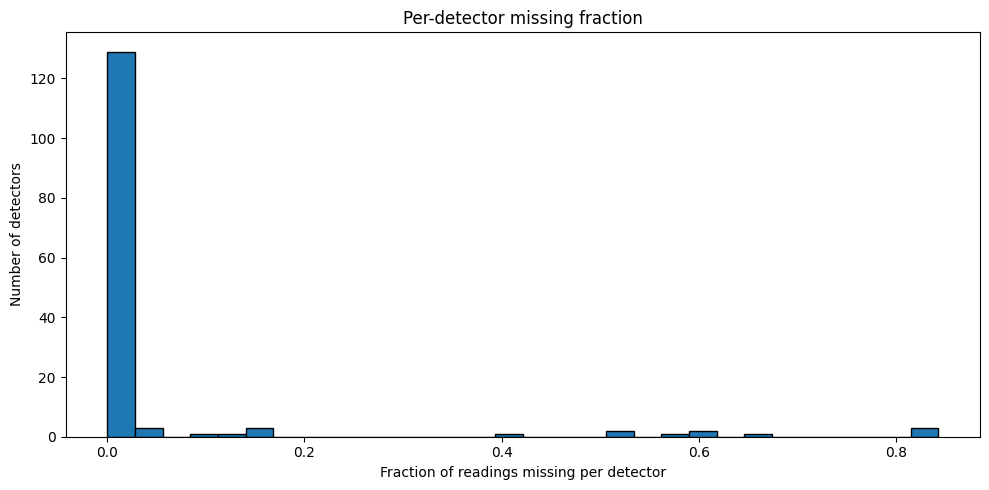

In [18]:
# --------------------------------------------
# 2a. Histogram: fraction missing per sensor
# --------------------------------------------
fig, ax = plt.subplots()
ax.hist(per_sensor_stats["missing_frac"], bins=30, edgecolor="k")
ax.set_xlabel("Fraction of readings missing per detector")
ax.set_ylabel("Number of detectors")
ax.set_title("Per-detector missing fraction")
plt.tight_layout()
plt.show()

This histogram shows how much data each detector is missing over the year. Most detectors are extremely reliable (often <1% missing), but a small subset is missing 50–80% of its readings.

For our project this is useful in two ways:

- It confirms that we have a **mostly healthy network with a minority of “problem sensors”**, which is a realistic setting for modeling information blackouts.
- It suggests a natural preprocessing step: detectors with extremely high missing fractions are better treated as **failed sensors** (to be filtered out or modeled separately), while the rest are good candidates for forecasting with occasional MNAR outages.


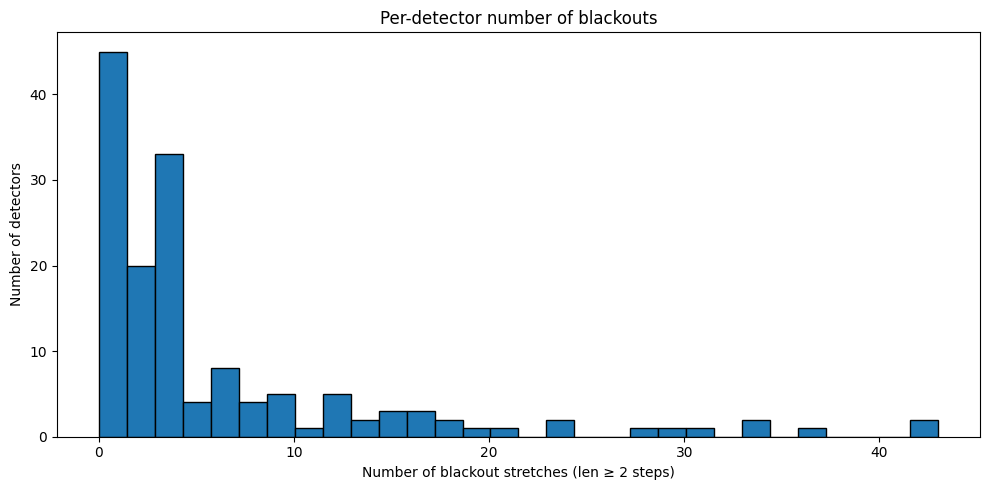

In [19]:
# --------------------------------------------
# 2b. Histogram: # of blackouts per sensor
# --------------------------------------------
fig, ax = plt.subplots()
ax.hist(per_sensor_stats["num_blackouts"], bins=30, edgecolor="k")
ax.set_xlabel("Number of blackout stretches (len ≥ 2 steps)")
ax.set_ylabel("Number of detectors")
ax.set_title("Per-detector number of blackouts")
plt.tight_layout()
plt.show()

This histogram counts how many blackout events (runs of ≥2 missing steps) each detector experiences.

- Many detectors have only **0–3 blackouts** in the entire year.
- A non-trivial tail of detectors has **10–40+ blackouts**, failing repeatedly.

This is exactly the behavior we want to study: **some sensors go down over and over again**, rather than failing once and dying. It motivates modeling the *blackout process itself* (how often a sensor goes down) instead of treating missing values as random noise.


[Blackout length distribution across all sensors]
Total blackout events (len ≥ 2 steps): 942
Blackout length in minutes (summary):
count       942.000000
mean       4246.422505
std       35691.511690
min          60.000000
25%          90.000000
50%         185.000000
75%         420.000000
max      442680.000000
dtype: float64


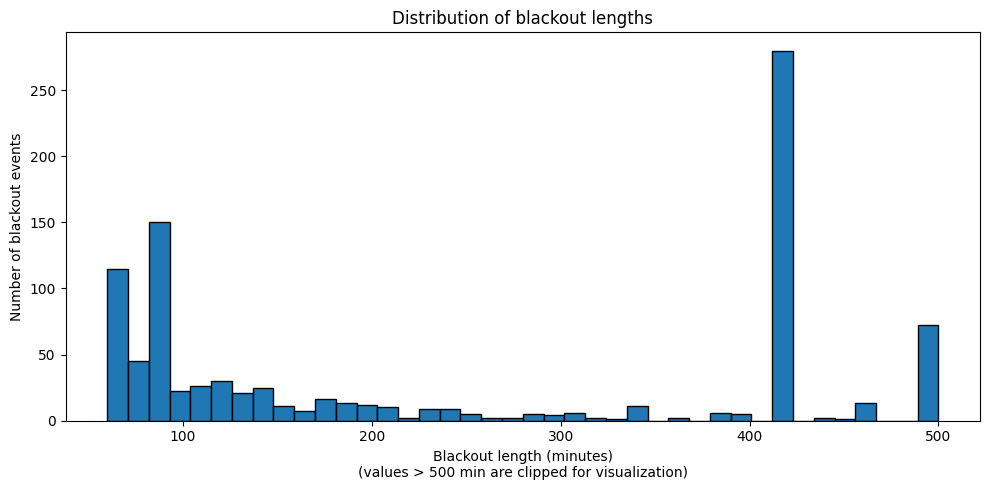

In [20]:

# ----------------------------------------------
# 3. Blackout length distribution (all sensors)
# ----------------------------------------------

print("\n[Blackout length distribution across all sensors]")

all_blackout_lengths_steps = np.array(all_blackout_lengths_steps)
all_blackout_lengths_minutes = all_blackout_lengths_steps * 5  # 5 minutes per step

print("Total blackout events (len ≥ 2 steps):", len(all_blackout_lengths_steps))
print("Blackout length in minutes (summary):")
print(pd.Series(all_blackout_lengths_minutes).describe())

# Histogram of blackout lengths in minutes (clip at, say, 500 min for visualization)
clip_max = 500
clipped = np.clip(all_blackout_lengths_minutes, 0, clip_max)

fig, ax = plt.subplots()
ax.hist(clipped, bins=40, edgecolor="k")
ax.set_xlabel("Blackout length (minutes)\n(values > "
              f"{clip_max} min are clipped for visualization)")
ax.set_ylabel("Number of blackout events")
ax.set_title("Distribution of blackout lengths")
plt.tight_layout()
plt.show()

This histogram shows how long each blackout event lasts (in minutes). We plot all events of length ≥10 minutes and clip anything longer than 500 minutes for visibility.

Key observations:

- The bulk of blackouts are **short to medium** (roughly 1–3 hours).
- There is also a clear cluster around **6–8+ hours**, and a visible spike near **≈420 minutes (~7 hours)**.
- Very long events (multi-day outages) exist but are rare.

The concentration around specific durations (e.g., ~7 hours) suggests **structured or scheduled outages** rather than purely random dropouts. That’s strong evidence for MNAR behavior: the duration of missingness depends on some hidden operational process (maintenance windows, nightly resets, etc.), which we can try to exploit in our models.



[Time-of-day / weekday missingness patterns]


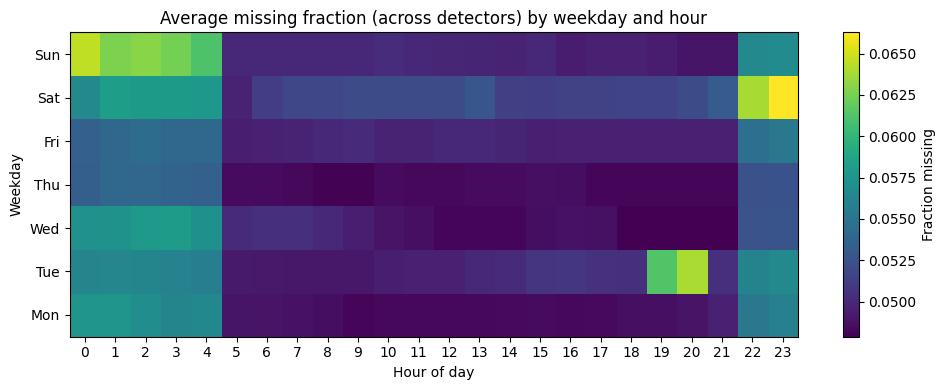

In [21]:
# -------------------------------------------------
# 4. Time-of-day / weekday patterns in missingness
#    - Heatmap over (weekday × hour)
# -------------------------------------------------

print("\n[Time-of-day / weekday missingness patterns]")

# Flatten missingness into long form: (time, detector, is_missing)
missing_long = missing.stack().to_frame("is_missing").reset_index()
# Columns are now: ["time", "detector", "is_missing"]

missing_long["hour"] = missing_long["time"].dt.hour
missing_long["weekday"] = missing_long["time"].dt.dayofweek  # 0=Mon, 6=Sun

# Average missing fraction over all detectors + time for each (weekday, hour)
heat = (
    missing_long
    .groupby(["weekday", "hour"])["is_missing"]
    .mean()
    .unstack("hour")  # rows = weekday, cols = hour
)

# Order rows as Monday..Sunday
heat = heat.reindex(index=[0, 1, 2, 3, 4, 5, 6])

weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(heat.values, aspect="auto", origin="lower")

ax.set_yticks(range(7))
ax.set_yticklabels(weekday_labels)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))

ax.set_xlabel("Hour of day")
ax.set_ylabel("Weekday")
ax.set_title("Average missing fraction (across detectors) by weekday and hour")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Fraction missing")

plt.tight_layout()
plt.show()

This heatmap shows the average fraction of missing readings across all detectors as a function of **weekday** (rows) and **hour of day** (columns).

Key patterns:

- **Sunday 00:00–05:00** has the highest missingness.
- **Saturday late night** and **Tuesday evenings (≈19:00–21:00)** also show elevated dropout.
- In contrast, **weekday daytime (≈08:00–17:00)** is very stable with minimal missing data.

So the chance that a reading is missing clearly depends on *when* we are in the week. That is exactly a **time-dependent MNAR mechanism**: the missingness pattern is driven by operational schedules (maintenance, nightly resets, low-usage periods), not just random noise. Our forecasting model can therefore try to use time-of-day/weekday as features for predicting sensor blackouts.

In [22]:
# -------------------------------------------------
# 5. Network-wide outages
#    - Fraction of detectors missing at each time
#    - Identify times where ≥ X% are down
# -------------------------------------------------

print("\n[Network-wide outages]")

missing_frac_time = mask.mean(axis=1)  # shape (T,), fraction missing at each timestamp

print("Overall mean missing fraction over time:", missing_frac_time.mean())
print("95th percentile of missing fraction over time:",
      np.quantile(missing_frac_time, 0.95))

# Threshold for "global" blackout (e.g., ≥ 10% detectors missing)
THRESH = 0.10
global_mask = missing_frac_time >= THRESH
global_blackouts = find_streaks(global_mask)

print(f"\nTime steps with missing_frac ≥ {THRESH:.2f}:",
      global_mask.sum())
print("Number of multi-sensor blackout intervals:", len(global_blackouts))

print("\nFirst few global blackout intervals:")
for (s, e) in global_blackouts[:10]:
    start_ts = timestamps[s]
    end_ts = timestamps[e]
    L = e - s + 1
    print(f"  {start_ts} → {end_ts}  (len={L} steps, "
          f"missing_frac_start≈{missing_frac_time[s]:.3f})")


[Network-wide outages]
Overall mean missing fraction over time: 0.05177277151347601
95th percentile of missing fraction over time: 0.07482993197278912

Time steps with missing_frac ≥ 0.10: 1673
Number of multi-sensor blackout intervals: 25

First few global blackout intervals:
  2015-01-16T00:10:00.000000000 → 2015-01-17T11:40:00.000000000  (len=427 steps, missing_frac_start≈0.116)
  2015-01-17T22:00:00.000000000 → 2015-01-18T00:25:00.000000000  (len=30 steps, missing_frac_start≈0.102)
  2015-01-18T01:55:00.000000000 → 2015-01-18T04:55:00.000000000  (len=37 steps, missing_frac_start≈0.116)
  2015-01-18T22:00:00.000000000 → 2015-01-19T00:55:00.000000000  (len=36 steps, missing_frac_start≈0.102)
  2015-02-07T20:50:00.000000000 → 2015-02-08T00:50:00.000000000  (len=49 steps, missing_frac_start≈0.122)
  2015-02-11T14:50:00.000000000 → 2015-02-11T17:50:00.000000000  (len=37 steps, missing_frac_start≈0.102)
  2015-03-18T01:35:00.000000000 → 2015-03-18T03:45:00.000000000  (len=27 steps, miss

We call a **network-wide blackout** any time interval where at least **10% of detectors are missing simultaneously**. These events correspond to cabinet-level or system-level failures rather than isolated sensor glitches.

Summary:

- Overall mean fraction of detectors missing at any time: **≈5.2%**
- 95th percentile of this fraction: **≈7.5%**
- Threshold for multi-sensor blackout: **10% of detectors missing**
- Total time steps above this threshold: **1,673**
- Number of distinct multi-sensor blackout intervals: **25**

Many of these intervals last from tens of minutes to several hours and line up with the spikes in the time-series plots. For our project, these events are important because they represent **spatially correlated blackouts**: multiple sensors go down together. That lets us study models that jointly predict both traffic and the *pattern of missingness across the network* (e.g., which subset of sensors is likely to fail at the same time).


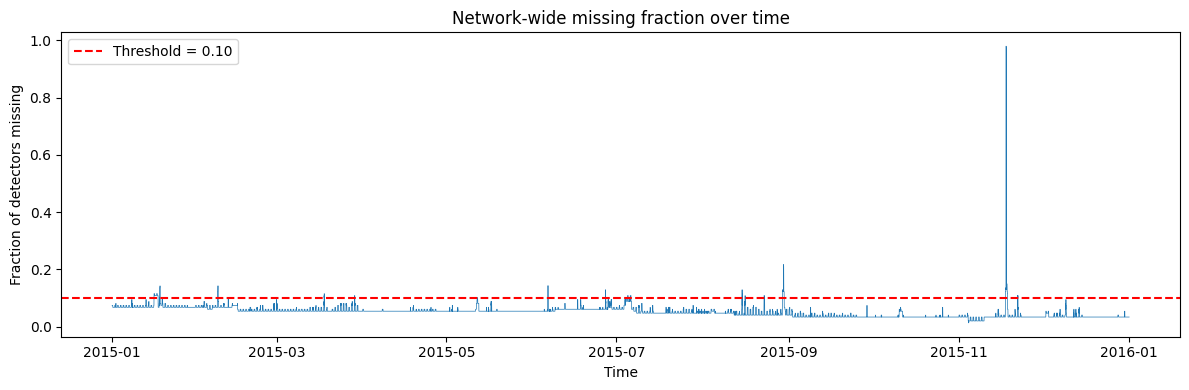

In [23]:
# ------------------------------------------------
# 5a. Plot: missing fraction over time (full year)
# ------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(timestamps, missing_frac_time, linewidth=0.5)
ax.axhline(THRESH, color="red", linestyle="--", label=f"Threshold = {THRESH:.2f}")
ax.set_xlabel("Time")
ax.set_ylabel("Fraction of detectors missing")
ax.set_title("Network-wide missing fraction over time")
ax.legend()
plt.tight_layout()
plt.show()

The full-year view shows that, on most days, only about 5–8% of detectors are missing at any given time, so the network is generally well-instrumented. However, there are repeated spikes where the missing fraction exceeds the 10% threshold, and a few extreme events where a large portion of the network drops out simultaneously. This suggests that missingness is not just random packet loss at individual sensors: there are genuine multi-sensor “blackout” episodes (likely maintenance, subsystem failures, or communication outages) superimposed on a relatively stable background. These global events are exactly the kind of structured MNAR behaviour that our project aims to model and forecast.

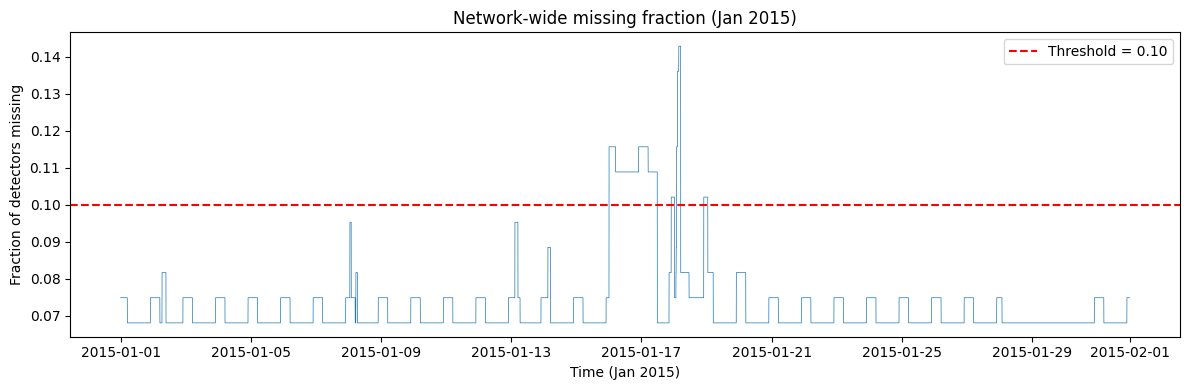

In [24]:

# --------------------------------------
# 5b. Zoomed-in plot for a sample month
# --------------------------------------

# Example: January 2015
start_zoom = pd.Timestamp("2015-01-01")
end_zoom = pd.Timestamp("2015-02-01")

zoom_mask = (wide.index >= start_zoom) & (wide.index < end_zoom)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(timestamps[zoom_mask], missing_frac_time[zoom_mask], linewidth=0.5)
ax.axhline(THRESH, color="red", linestyle="--", label=f"Threshold = {THRESH:.2f}")
ax.set_xlabel("Time (Jan 2015)")
ax.set_ylabel("Fraction of detectors missing")
ax.set_title("Network-wide missing fraction (Jan 2015)")
ax.legend()
plt.tight_layout()
plt.show()

Zooming into January 2015 makes the structure of these outages clearer. We see a long blackout around 16–18 January where more than 10% of detectors are down for many consecutive hours, surrounded by shorter spikes that still cross the threshold. In between these episodes the missing fraction settles into a lower, almost periodic band around 6–8%, which likely reflects a fixed subset of chronically problematic sensors. This pattern supports our modeling goal: we are dealing with a mixture of persistent detector-level issues and intermittent, network-level blackouts, both of which need to be captured when we build a generative model and design forecasting algorithms that are robust to frequent sensor outages.

### Summary and next steps

This exploratory analysis shows that the Seattle loop data are mostly complete, but with **highly structured missingness**. Most detectors have <1% missing readings, yet a small subset experiences frequent, long blackouts, and there are clear **network-wide outage episodes** where >10% of sensors drop out together. Missingness also varies systematically with **time of day and weekday**, especially around late-night / early-morning windows, which is consistent with maintenance or system resets rather than random noise.

Taken together, this confirms that we are working with a realistic MNAR setting: outages are correlated across time and across sensors, not independent. In the next stage, we will use these findings to (i) define a clean blackout label set (per-sensor and global), (ii) filter or down-weight chronically broken detectors, and (iii) construct forecasting datasets that explicitly condition on blackout history, so we can build and evaluate models that are robust to frequent sensor failures.
